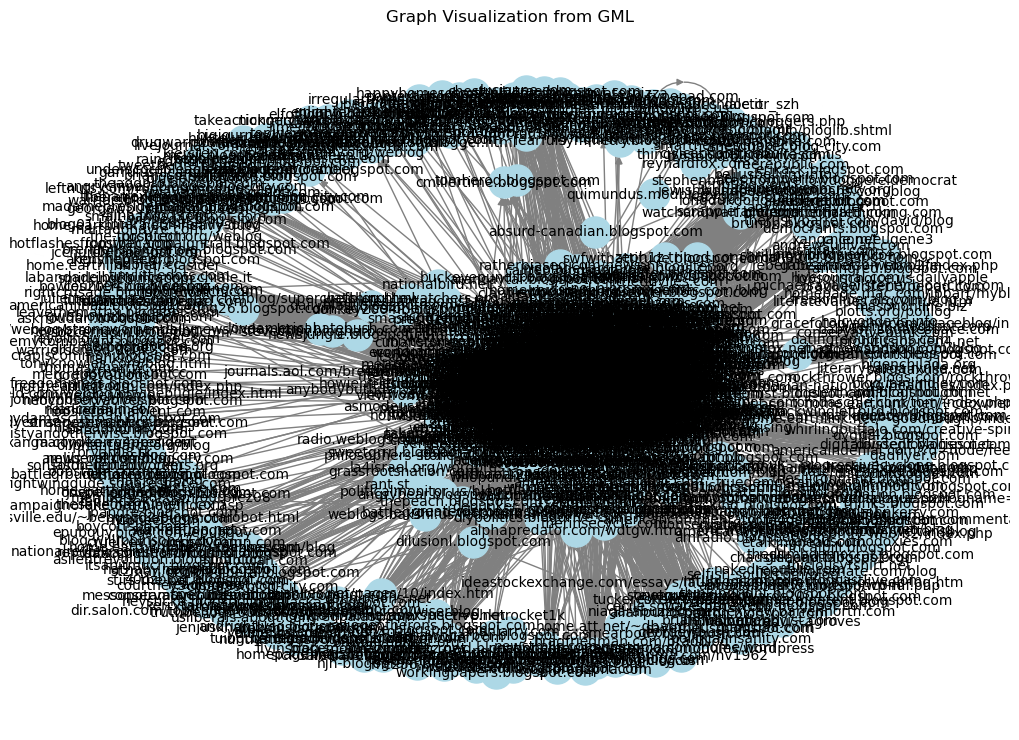

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla

file_path = "/Users/efang/Desktop/coding/Intro-to-ML/CSDS446/data/polblogs.gml"
G = nx.read_gml(file_path)
pos = nx.spring_layout(G, seed=42)  
plt.figure(figsize=(10, 7))
nx.draw(G, pos, with_labels=True, node_size=500, node_color="lightblue", edge_color="gray", font_size=10)
plt.title("Graph Visualization from GML")
plt.show()


In [4]:
G_undirected = nx.Graph()
G_undirected.add_nodes_from(G.nodes(data=True))

for u, v in G.edges():
    if not G_undirected.has_edge(v, u):
        G_undirected.add_edge(v, u)



In [7]:
def largest_connected_component(G_undirected, min_size=3):
    comps = list(nx.connected_components(G_undirected))
    big_comps = [c for c in comps if len(c) >= min_size]
    largest_comp = max(big_comps, key=len)
    return G_undirected.subgraph(largest_comp).copy()

In [12]:
def build_matrices(G):
    A = nx.to_scipy_sparse_array(G, format='csr')  
    degrees = [val for (node, val) in G.degree()]
    D = sp.diags(degrees, format='csr')
    
    return A, D

def spectral_ratio_cut(G):
    A, D = build_matrices(G)
    L = D - A  

    vals, vecs = spla.eigsh(L, k=2, which='SM')
    
    idx_sorted = np.argsort(vals)
    fiedler_vec = vecs[:, idx_sorted[1]]  # second-smallest eigenvalue
    partition = (fiedler_vec >= 0)
    return partition

def spectral_normalized_cut(G):
    A, D = build_matrices(G)
    D_inv_sqrt = sp.diags(np.power(np.array(D.diagonal()), -0.5), format='csr')
    L_sym = sp.eye(G.number_of_nodes()) - D_inv_sqrt @ A @ D_inv_sqrt
    vals, vecs = spla.eigsh(L_sym, k=2, which='SM')
    idx_sorted = np.argsort(vals)
    fiedler_vec = vecs[:, idx_sorted[1]]
    
    partition = (fiedler_vec >= 0)
    return partition

def spectral_modularity_partition(G):
    A, D = build_matrices(G)
    degrees = np.array(D.diagonal())
    m = degrees.sum() / 2  
    k_out = degrees.reshape(-1, 1)

    A_dense = A.toarray() 
    kkT = (k_out @ k_out.T) / (2.0 * m)
    B = A_dense - kkT

    vals, vecs = np.linalg.eig(B)  
    idx_max = np.argmax(vals.real)  # index of largest eigenvalu
    leading_vec = vecs[:, idx_max].real

    partition = (leading_vec >= 0)
    return partition

def compute_agreement_fraction(G, partition, label_attr='value'):
    nodes = list(G.nodes())
    node_to_idx = {n: i for i, n in enumerate(nodes)}
    
    labels = np.array([G.nodes[n][label_attr] for n in nodes])
    part_bool = np.array([partition[node_to_idx[n]] for n in nodes])

    label_is_D = (labels == 'D')

    match_D = (part_bool == label_is_D)  
    frac_D = match_D.mean()

    match_R = (part_bool != label_is_D)
    frac_R = match_R.mean()
    if frac_D > frac_R:
        return frac_D, "D" 
    else:
        return frac_R, "R"  



In [13]:


G_main = largest_connected_component(G_undirected, min_size=3)

print("Nodes in main component:", G_main.number_of_nodes())
print("Edges in main component:", G_main.number_of_edges())

part_ratio = spectral_ratio_cut(G_main)
ratio_agreement, ee = compute_agreement_fraction(G_main, part_ratio, label_attr='value')
print(f"RatioCut agreement: {ratio_agreement:.3f}", ee)

part_ncut = spectral_normalized_cut(G_main)
ncut_agreement, ee = compute_agreement_fraction(G_main, part_ncut, label_attr='value')
print(f"NormalizedCut agreement: {ncut_agreement:.3f}", ee)

part_mod = spectral_modularity_partition(G_main)
mod_agreement, ee = compute_agreement_fraction(G_main, part_mod, label_attr='value')
print(f"Modularity agreement: {mod_agreement:.3f}", ee)

Nodes in main component: 1222
Edges in main component: 16717
RatioCut agreement: 0.995 R
NormalizedCut agreement: 0.953 R
Modularity agreement: 0.554 D
